# AutoML Image Classification: With Rotation (Digits)

![](imgs/rotation.png)

In [1]:
import random as rn
from abc import ABC, abstractmethod

import autokeras as ak
import h2o
import matplotlib.pyplot as plt
import numpy as np
from h2o.automl import H2OAutoML
from numpy.random import RandomState
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier

from dpemu import runner
from dpemu.filters.image import RotationPIL
from dpemu.nodes import Array
from dpemu.nodes.series import Series
from dpemu.plotting_utils import visualize_scores, print_results_by_model
from dpemu.utils import generate_tmpdir

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [2]:
def get_data():
    random_state = RandomState(42)
    digits = load_digits()
    return train_test_split(digits["data"], digits["target"], test_size=.2, random_state=random_state)

In [3]:
def get_err_root_node():
    err_img_node = Array(reshape=(8, 8))
    err_root_node = Series(err_img_node)
    err_img_node.addfilter(RotationPIL("max_angle"))
    return err_root_node

In [4]:
def get_err_params_list():
    angle_steps = np.linspace(0, 84, num=8)
    err_params_list = [{"max_angle": a} for a in angle_steps]
    return err_params_list

In [5]:
class Preprocessor:

    def run(self, train_data, test_data, params):
        return train_data, test_data, {}

In [6]:
class AbstractModel(ABC):

    def __init__(self):
        self.time_limit_mins = 60*1
        self.seed = 42
        self.random_state = RandomState(self.seed)
        np.random.seed(self.seed)

    @abstractmethod
    def get_fitted_model(self, train_data, train_labels, params):
        pass

    @abstractmethod
    def get_accuracy(self, data, labels, fitted_model, params):
        pass

    @abstractmethod
    def get_best_pipeline(self, fitted_model):
        pass

    def run(self, train_data, test_data, params):
        train_labels = params["train_labels"]
        test_labels = params["test_labels"]

        fitted_model = self.get_fitted_model(train_data, train_labels, params)

        return {
            "test_acc": self.get_accuracy(test_data, test_labels, fitted_model, params),
            "train_acc": self.get_accuracy(train_data, train_labels, fitted_model, params),
            "best_pipeline": self.get_best_pipeline(fitted_model),
        }

class TPOTClassifierModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return TPOTClassifier(
            max_time_mins=self.time_limit_mins,
            n_jobs=-1,
            random_state=self.seed,
            verbosity=1,
        ).fit(train_data, train_labels)
    
    def get_accuracy(self, data, labels, fitted_model, params):
        return round(fitted_model.score(data, labels), 3)

    def get_best_pipeline(self, fitted_model):
        return [step[1] for step in fitted_model.fitted_pipeline_.steps]

class H2OAutoMLModel(AbstractModel):

    def __init__(self):
        super().__init__()
        h2o.init(name=f"#{rn.SystemRandom().randint(1, 2**30)}", nthreads=16)
        h2o.no_progress()

    def get_fitted_model(self, train_data, train_labels, params):
        train_data = h2o.H2OFrame(np.concatenate((train_data, train_labels.reshape(-1, 1)), axis=1))
        x = np.array(train_data.columns)[:-1].tolist()
        y = np.array(train_data.columns)[-1].tolist()
        train_data[y] = train_data[y].asfactor()
        aml = H2OAutoML(max_runtime_secs=60*self.time_limit_mins, seed=self.seed)
        aml.train(x=x, y=y, training_frame=train_data)
        return aml

    def get_accuracy(self, data, labels, fitted_model, params):
        data = h2o.H2OFrame(np.concatenate((data, labels.reshape(-1, 1)), axis=1))
        y = np.array(data.columns)[-1].tolist()
        data[y] = data[y].asfactor()
        pred = fitted_model.predict(data).as_data_frame(header=False)["predict"].values.astype(int)
        return np.round(np.mean(pred == labels), 3)

    def get_best_pipeline(self, fitted_model):
        leader_params = fitted_model.leader.get_params()
        best_pipeline = [leader_params["model_id"]["actual_value"]["name"]]
        if "base_models" in leader_params:
            for base_model in leader_params["base_models"]["actual_value"]:
                best_pipeline.append(base_model["name"])
        h2o.cluster().shutdown()
        return best_pipeline

class AutoKerasModel(AbstractModel):

    def __init__(self):
        super().__init__()
        import tensorflow as tf
        tf.set_random_seed(self.seed)
        import torch
        torch.multiprocessing.set_sharing_strategy("file_system")
        torch.manual_seed(self.seed)

    def get_fitted_model(self, x_train, y_train, params):
        s = np.sqrt(x_train.shape[1]).astype(int)
        x_train = x_train.reshape((len(x_train), s, s)).astype(np.uint8)
        x_train = x_train.reshape(x_train.shape + (1,))
        y_train = y_train.astype(np.uint8)
        clf = ak.ImageClassifier(augment=False, path=generate_tmpdir(), verbose=False)
        clf.fit(x_train, y_train, time_limit=60*self.time_limit_mins)
        return clf

    def get_accuracy(self, x, y, clf, params):
        s = np.sqrt(x.shape[1]).astype(int)
        x = x.reshape((len(x), s, s)).astype(np.uint8)
        x = x.reshape(x.shape + (1,))
        y = y.astype(np.uint8)
        y_pred = clf.predict(x)
        return np.round(accuracy_score(y_true=y, y_pred=y_pred), 3)

    def get_best_pipeline(self, clf):
        return [m for i, m in enumerate(clf.cnn.best_model.produce_model().modules()) if i > 0]

In [7]:
def get_model_params_dict_list(train_labels, test_labels):
    model_params_base = {"train_labels": train_labels, "test_labels": test_labels}
    return [
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        {
            "model": AutoKerasModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": AutoKerasModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
    ]

In [8]:
def visualize(df):
    visualize_scores(
        df,
        score_names=["test_acc", "train_acc"],
        is_higher_score_better=[True, True],
        err_param_name="max_angle",
        title="Classification scores with added error"
    )
    plt.show()

In [9]:
train_data, test_data, train_labels, test_labels = get_data()

df = runner.run(
    train_data=train_data,
    test_data=test_data,
    preproc=Preprocessor,
    preproc_params=None,
    err_root_node=get_err_root_node(),
    err_params_list=get_err_params_list(),
    model_params_dict_list=get_model_params_dict_list(train_labels, test_labels),
)

  0%|          | 0/8 [00:00<?, ?it/s]

60.344500266666664 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=gini, max_features=0.4, min_samples_leaf=6, min_samples_split=4, n_estimators=100), n_neighbors=5, p=2, weights=distance)

60.55038173333333 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

LogisticRegression(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), C=15.0, dual=False, penalty=l2)

61.53614733333333 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(input_matrix, n_neighbors=12, p=2, weights=distance)

62.27830526666666 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

LogisticRegression(PolynomialFeatures(StandardScaler(input_matrix), degree=2, include_bias=False, interaction_only=False), C=25.0, dual=False, penalty=l1)

63.50868813333333 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

ExtraTreesClassifier(LinearSVC(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), C=15.0, dual=False, loss=squared_hinge, penalty=l2, tol=0.1), bootstrap=False, criterion=gini, max_features=0.25, min_samples_leaf=3, min_samples_split=9, n_estimators=100)

63.66282891666666 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

LogisticRegression(PolynomialFeatures(ExtraTreesClassifier(input_matrix, bootstrap=True, criterion=gini, max_features=1.0, min_samples_leaf=9, min_samples_split=2, n_estimators=100), degree=2, include_bias=False, interaction_only=False), C=25.0, dual=False, penalty=l1)

64.92309585 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(KNeighborsClassifier(input_matrix, n_neighbors=6, p=1, weights=distance), n_neighbors=3, p=2, weights=distance)

61.45601138333333 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(ExtraTreesClassifier(BernoulliNB(input_matrix, alpha=0.01, fit_prior=True), bootstrap=False, criterion=entropy, max_features=0.25, min_samples_leaf=5, min_samples_split=10, n_estimators=100), n_neighbors=3, p=2, weights=distance)

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp053a04yr

  JVM stdout: /wrk/users/thalvari/tmp053a04yr/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp053a04yr/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#327529380
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


62.66928266666666 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(ExtraTreesClassifier(BernoulliNB(input_matrix, alpha=0.01, fit_prior=True), bootstrap=False, criterion=entropy, max_features=0.25, min_samples_leaf=5, min_samples_split=10, n_estimators=100), n_neighbors=3, p=2, weights=distance)

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp_2_20438

  JVM stdout: /wrk/users/thalvari/tmp_2_20438/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp_2_20438/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54323

Connecting to H2O server at http://127.0.0.1:54323 ..

.

 successful.

H2O cluster uptime:,06 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#571086289
H2O cluster total nodes:,1
H2O cluster free memory:,26.63 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


61.413508783333334 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(LogisticRegression(input_matrix, C=20.0, dual=True, penalty=l2), n_neighbors=3, p=1, weights=distance)

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpxscc7zy5

  JVM stdout: /wrk/users/thalvari/tmpxscc7zy5/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpxscc7zy5/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54325

Connecting to H2O server at http://127.0.0.1:54325 ..

.

 successful.

H2O cluster uptime:,04 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#283219249
H2O cluster total nodes:,1
H2O cluster free memory:,26.63 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


60.71279618333333 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(LogisticRegression(input_matrix, C=20.0, dual=True, penalty=l2), n_neighbors=3, p=1, weights=distance)

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmph8j6a__x

  JVM stdout: /wrk/users/thalvari/tmph8j6a__x/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmph8j6a__x/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54327

Connecting to H2O server at http://127.0.0.1:54327 ..

.

 successful.

H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#735630719
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


64.58997028333333 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(MultinomialNB(input_matrix, alpha=0.001, fit_prior=False), n_neighbors=3, p=2, weights=distance)

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpoxzb7ehg

  JVM stdout: /wrk/users/thalvari/tmpoxzb7ehg/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpoxzb7ehg/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54329

Connecting to H2O server at http://127.0.0.1:54329 ..

.

 successful.

H2O cluster uptime:,03 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#76938772
H2O cluster total nodes:,1
H2O cluster free memory:,26.63 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


62.13013036666667 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(MinMaxScaler(input_matrix), n_neighbors=3, p=2, weights=distance)

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp0uo7nk25

  JVM stdout: /wrk/users/thalvari/tmp0uo7nk25/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp0uo7nk25/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54331

Connecting to H2O server at http://127.0.0.1:54331 ..

.

 successful.

H2O cluster uptime:,07 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#659835378
H2O cluster total nodes:,1
H2O cluster free memory:,26.64 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"locked, healthy"


64.29375045 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(MinMaxScaler(input_matrix), n_neighbors=3, p=2, weights=distance)

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpehsjf_ge

  JVM stdout: /wrk/users/thalvari/tmpehsjf_ge/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpehsjf_ge/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54335

Connecting to H2O server at http://127.0.0.1:54335 ..

.

 successful.

H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#1002807970
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


147.30316128333334 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

LogisticRegression(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), C=10.0, dual=False, penalty=l2)

H2O session _sid_81df closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpf5vlakgh

  JVM stdout: /wrk/users/thalvari/tmpf5vlakgh/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpf5vlakgh/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54333

Connecting to H2O server at http://127.0.0.1:54333 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#495738534
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_a361 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpvch4d8my

  JVM stdout: /wrk/users/thalvari/tmpvch4d8my/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpvch4d8my/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,04 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#554925828
H2O cluster total nodes:,1
H2O cluster free memory:,26.63 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_a1fe closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpltvrec47

  JVM stdout: /wrk/users/thalvari/tmpltvrec47/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpltvrec47/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54323

Connecting to H2O server at http://127.0.0.1:54323 ..

.

 successful.

H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#840519436
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_aea7 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp7rltvask

  JVM stdout: /wrk/users/thalvari/tmp7rltvask/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp7rltvask/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54325

Connecting to H2O server at http://127.0.0.1:54325 ..

.

 successful.

H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#969460466
H2O cluster total nodes:,1
H2O cluster free memory:,26.64 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_bf7a closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpjgl75sz3

  JVM stdout: /wrk/users/thalvari/tmpjgl75sz3/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpjgl75sz3/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54327

Connecting to H2O server at http://127.0.0.1:54327 ..

.

 successful.

H2O cluster uptime:,04 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#913791845
H2O cluster total nodes:,1
H2O cluster free memory:,26.64 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_aa2c closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpkv_dke3r

  JVM stdout: /wrk/users/thalvari/tmpkv_dke3r/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpkv_dke3r/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54331

Connecting to H2O server at http://127.0.0.1:54331 ..

.

 successful.

H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#783821304
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8936 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpo_y0ci8j

  JVM stdout: /wrk/users/thalvari/tmpo_y0ci8j/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpo_y0ci8j/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54329

Connecting to H2O server at http://127.0.0.1:54329 ..

.

 successful.

H2O cluster uptime:,05 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#691445177
H2O cluster total nodes:,1
H2O cluster free memory:,26.64 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


60.94537248333334 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(input_matrix, n_neighbors=3, p=2, weights=distance)

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpxhhxjqka

  JVM stdout: /wrk/users/thalvari/tmpxhhxjqka/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpxhhxjqka/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54335

Connecting to H2O server at http://127.0.0.1:54335 ..

.

 successful.

H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#881754642
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_9301 closed.

H2O session _sid_bf22 closed.

H2O session _sid_ab23 closed.

H2O session _sid_ae48 closed.

H2O session _sid_835f closed.

H2O session _sid_b018 closed.

H2O session _sid_8a63 closed.

H2O session _sid_8055 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpn_5ut3p3

  JVM stdout: /wrk/users/thalvari/tmpn_5ut3p3/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpn_5ut3p3/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,08 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#104139076
H2O cluster total nodes:,1
H2O cluster free memory:,26.62 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_9580 closed.

 12%|█▎        | 1/8 [6:06:30<42:45:32, 21990.38s/it]

 25%|██▌       | 2/8 [6:06:54<25:40:03, 15400.51s/it]

 62%|██████▎   | 5/8 [6:14:37<9:01:19, 10826.62s/it] 

 75%|███████▌  | 6/8 [7:53:53<5:12:11, 9365.59s/it] 

100%|██████████| 8/8 [7:53:53<00:00, 3554.21s/it]  

'AutoKeras #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.983,0.995,0.222,0,3610
12,0.964,0.994,0.259,0,3609.85
24,0.919,0.989,0.273,0,3604.67
36,0.886,0.976,0.283,0,3603.78
48,0.861,0.963,0.249,0,3607.54
60,0.861,0.987,0.221,0,3603.77
72,0.764,0.917,0.275,0,3613.65
84,0.689,0.868,0.312,0,3606.05


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21
0,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",GlobalAvgPool2d(),Dropout2d(p=0.25),"Linear(in_features=64, out_features=64, bias=True)",ReLU(),"Linear(in_features=64, out_features=10, bias=True)",nan,nan,nan,nan,nan
12,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",GlobalAvgPool2d(),Dropout2d(p=0.25),"Linear(in_features=64, out_features=64, bias=True)",ReLU(),"Linear(in_features=64, out_features=10, bias=True)",nan,nan,nan,nan,nan
24,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",GlobalAvgPool2d(),Dropout2d(p=0.25),"Linear(in_features=64, out_features=64, bias=True)",ReLU(),"Linear(in_features=64, out_features=10, bias=True)",nan,nan,nan,nan,nan
36,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",GlobalAvgPool2d(),Dropout2d(p=0.25),"Linear(in_features=64, out_features=64, bias=True)",ReLU(),"Linear(in_features=64, out_features=10, bias=True)",nan,nan,nan,nan,nan
48,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 6

'AutoKerasClean #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.983,0.995,0.222,0,3602.94
12,0.967,0.995,0.259,0,3601.48
24,0.844,0.995,0.273,0,3610.7
36,0.708,0.995,0.283,0,3605.6
48,0.619,0.999,0.249,0,3611.53
60,0.508,0.999,0.221,0,3622.75
72,0.456,0.995,0.275,0,3602.55
84,0.394,0.995,0.312,0,3605.78


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76
0,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",GlobalAvgPool2d(),Dropout2d(p=0.25),"Linear(in_features=64, out_features=64, bias=True)",ReLU(),"Linear(in_features=64, out_features=10, bias=True)",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
12,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",GlobalAvgPool2d(),Dropout2d(p=0.25),"Linear(in_features=64, out_features=64, bias=True)",ReLU(),"Linear(in_features=64, out_features=10, bias=True)",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
24,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",GlobalAvgPool2d(),Dropout2d(p=0.25),"Linear(in_features=64, out_features=64, bias=True)",ReLU(),"Linear(in_features=64, out_features=10, bias=True)",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
36,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, ker

'H2OAutoML #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.986,1,0.222,0,3512.63
12,0.978,1,0.259,0,3646.02
24,0.947,1,0.273,0,3679.61
36,0.947,1,0.283,0,3662.96
48,0.936,1,0.249,0,3602.03
60,0.911,1,0.221,0,4575.75
72,0.922,1,0.275,0,3622.72
84,0.903,1,0.312,0,3467.36


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76,pipe_77,pipe_78,pipe_79,pipe_80,pipe_81,pipe_82,pipe_83,pipe_84,pipe_85,pipe_86,pipe_87,pipe_88,pipe_89,pipe_90,pipe_91,pipe_92,pipe_93
0,StackedEnsemble_AllModels_AutoML_20191022_040303,DeepLearning_grid_1_AutoML_20191022_040303_model_8,GBM_grid_1_AutoML_20191022_040303_model_31,GBM_grid_1_AutoML_20191022_040303_model_18,DeepLearning_grid_1_AutoML_20191022_040303_model_12,GBM_grid_1_AutoML_20191022_040303_model_19,DeepLearning_grid_1_AutoML_20191022_040303_model_1,DeepLearning_grid_1_AutoML_20191022_040303_model_2,DeepLearning_grid_1_AutoML_20191022_040303_model_11,DeepLearning_grid_1_AutoML_20191022_040303_model_7,DeepLearning_grid_1_AutoML_20191022_040303_model_3,XGBoost_grid_1_AutoML_20191022_040303_model_13,GBM_grid_1_AutoML_20191022_040303_model_15,GBM_2_AutoML_20191022_040303,GBM_grid_1_AutoML_20191022_040303_model_3,GBM_3_AutoML_20191022_040303,GBM_grid_1_AutoML_20191022_040303_model_26,GBM_grid_1_AutoML_20191022_040303_model_6,GBM_grid_1_AutoML_20191022_040303_model_27,GBM_grid_1_AutoML_20191022_040303_model_20,GBM_5_AutoML_20191022_040303,GBM_grid_1_AutoML_20191022_040303_model_12,GBM_4_AutoML_20191022_040303,GLM_grid_1_AutoML_20191022_040303_model_1,GBM_grid_1_AutoML_20191022_040303_model_17,XRT_1_AutoML_20191022_040303,GBM_grid_1_AutoML_20191022_040303_model_1,GBM_grid_1_AutoML_20191022_040303_model_10,XGBoost_grid_1_AutoML_20191022_040303_model_8,GBM_1_AutoML_20191022_040303,GBM_grid_1_AutoML_20191022_040303_model_14,GBM_grid_1_AutoML_20191022_040303_model_11,XGBoost_grid_1_AutoML_20191022_040303_model_30,GBM_grid_1_AutoML_20191022_040303_model_16,GBM_grid_1_AutoML_20191022_040303_model_24,DRF_1_AutoML_20191022_040303,XGBoost_grid_1_AutoML_20191022_040303_model_17,DeepLearning_grid_1_AutoML_20191022_040303_model_5,GBM_grid_1_AutoML_20191022_040303_model_32,GBM_grid_1_AutoML_20191022_040303_model_13,DeepLearning_grid_1_AutoML_20191022_040303_model_6,XGBoost_3_AutoML_20191022_040303,DeepLearning_grid_1_AutoML_20191022_040303_model_13,XGBoost_1_AutoML_20191022_040303,XGBoost_grid_1_AutoML_20191022_040303_model_25,XGBoost_grid_1_AutoML_20191022_040303_model_21,XGBoost_grid_1_AutoML_20191022_040303_model_18,DeepLearning_grid_1_AutoML_20191022_040303_model_4,XGBoost_grid_1_AutoML_20191022_040303_model_26,XGBoost_grid_1_AutoML_20191022_040303_model_15,GBM_grid_1_AutoML_20191022_040303_model_8,DeepLearning_grid_1_AutoML_20191022_040303_model_14,GBM_grid_1_AutoML_20191022_040303_model_9,XGBoost_grid_1_AutoML_20191022_040303_model_20,XGBoost_grid_1_AutoML_20191022_040303_model_27,DeepLearning_grid_1_AutoML_20191022_040303_model_9,XGBoost_grid_1_AutoML_20191022_040303_model_4,XGBoost_grid_1_AutoML_20191022_040303_model_31,XGBoost_grid_1_AutoML_20191022_040303_model_2,GBM_grid_1_AutoML_20191022_040303_model_29,XGBoost_grid_1_AutoML_20191022_040303_model_29,GBM_grid_1_AutoML_20191022_040303_model_28,DeepLearning_grid_1_AutoML_20191022_040303_model_10,XGBoost_grid_1_AutoML_20191022_040303_model_28,XGBoost_grid_1_AutoML_20191022_040303_model_3,XGBoost_grid_1_AutoML_20191022_040303_model_23,XGBoost_grid_1_AutoML_20191022_040303_model_7,XGBoost_grid_1_AutoML_20191022_040303_model_19,GBM_grid_1_AutoML_20191022_040303_model_25,GBM_grid_1_AutoML_20191022_040303_model_21,XGBoost_grid_1_AutoML_20191022_040303_model_32,XGBoost_2_AutoML_20191022_040303,GBM_grid_1_AutoML_20191022_040303_model_30,GBM_grid_1_AutoML_20191022_040303_model

'H2OAutoMLClean #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.986,1,0.222,0,3637.28
12,0.956,1,0.259,0,3723.14
24,0.831,1,0.273,0,3675.84
36,0.692,1,0.283,0,3624.2
48,0.561,1,0.249,0,3968.65
60,0.472,1,0.221,0,4128.89
72,0.425,1,0.275,0,3841.81
84,0.392,1,0.312,0,3706.03


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76,pipe_77,pipe_78,pipe_79,pipe_80,pipe_81,pipe_82,pipe_83,pipe_84,pipe_85,pipe_86,pipe_87,pipe_88,pipe_89,pipe_90,pipe_91,pipe_92
0,StackedEnsemble_AllModels_AutoML_20191022_050126,DeepLearning_grid_1_AutoML_20191022_050126_model_8,DeepLearning_grid_1_AutoML_20191022_050126_model_11,GBM_grid_1_AutoML_20191022_050126_model_18,DeepLearning_grid_1_AutoML_20191022_050126_model_2,GBM_grid_1_AutoML_20191022_050126_model_19,DeepLearning_grid_1_AutoML_20191022_050126_model_1,XGBoost_grid_1_AutoML_20191022_050126_model_13,GBM_grid_1_AutoML_20191022_050126_model_15,GBM_2_AutoML_20191022_050126,DeepLearning_grid_1_AutoML_20191022_050126_model_10,DeepLearning_grid_1_AutoML_20191022_050126_model_4,GBM_grid_1_AutoML_20191022_050126_model_3,GBM_grid_1_AutoML_20191022_050126_model_31,GBM_3_AutoML_20191022_050126,DeepLearning_grid_1_AutoML_20191022_050126_model_7,GBM_grid_1_AutoML_20191022_050126_model_26,GBM_grid_1_AutoML_20191022_050126_model_6,GBM_grid_1_AutoML_20191022_050126_model_27,GBM_grid_1_AutoML_20191022_050126_model_20,DeepLearning_grid_1_AutoML_20191022_050126_model_3,GBM_5_AutoML_20191022_050126,GBM_grid_1_AutoML_20191022_050126_model_12,DeepLearning_grid_1_AutoML_20191022_050126_model_5,GBM_4_AutoML_20191022_050126,GLM_grid_1_AutoML_20191022_050126_model_1,GBM_grid_1_AutoML_20191022_050126_model_17,XRT_1_AutoML_20191022_050126,GBM_grid_1_AutoML_20191022_050126_model_1,GBM_grid_1_AutoML_20191022_050126_model_10,XGBoost_grid_1_AutoML_20191022_050126_model_8,GBM_1_AutoML_20191022_050126,GBM_grid_1_AutoML_20191022_050126_model_14,GBM_grid_1_AutoML_20191022_050126_model_11,GBM_grid_1_AutoML_20191022_050126_model_16,GBM_grid_1_AutoML_20191022_050126_model_24,DRF_1_AutoML_20191022_050126,XGBoost_grid_1_AutoML_20191022_050126_model_17,GBM_grid_1_AutoML_20191022_050126_model_13,XGBoost_3_AutoML_20191022_050126,XGBoost_1_AutoML_20191022_050126,XGBoost_grid_1_AutoML_20191022_050126_model_25,XGBoost_grid_1_AutoML_20191022_050126_model_21,XGBoost_grid_1_AutoML_20191022_050126_model_18,XGBoost_grid_1_AutoML_20191022_050126_model_26,XGBoost_grid_1_AutoML_20191022_050126_model_15,GBM_grid_1_AutoML_20191022_050126_model_8,DeepLearning_grid_1_AutoML_20191022_050126_model_6,DeepLearning_grid_1_AutoML_20191022_050126_model_9,GBM_grid_1_AutoML_20191022_050126_model_9,XGBoost_grid_1_AutoML_20191022_050126_model_20,XGBoost_grid_1_AutoML_20191022_050126_model_27,XGBoost_grid_1_AutoML_20191022_050126_model_4,XGBoost_grid_1_AutoML_20191022_050126_model_2,GBM_grid_1_AutoML_20191022_050126_model_29,GBM_grid_1_AutoML_20191022_050126_model_28,XGBoost_grid_1_AutoML_20191022_050126_model_28,XGBoost_grid_1_AutoML_20191022_050126_model_3,DeepLearning_grid_1_AutoML_20191022_050126_model_12,XGBoost_grid_1_AutoML_20191022_050126_model_23,XGBoost_grid_1_AutoML_20191022_050126_model_7,XGBoost_grid_1_AutoML_20191022_050126_model_19,GBM_grid_1_AutoML_20191022_050126_model_25,GBM_grid_1_AutoML_20191022_050126_model_21,XGBoost_2_AutoML_20191022_050126,GBM_grid_1_AutoML_20191022_050126_model_30,GBM_grid_1_AutoML_20191022_050126_model_7,GBM_grid_1_AutoML_20191022_050126_model_23,XGBoost_grid_1_AutoML_20191022_050126_model_5,XGBoost_grid_1_AutoML_20191022_050126_model_22,XGBoost_grid_1_AutoML_20191022_050126_model_12,XGBoost_grid_1_AutoML_20191022_050126_model_29,GBM_grid_1_AutoML_20191022_050126_model_5,GBM_grid_1_AutoML_20191022_050126_model_32,XGBoost_grid_1_AutoML_201

'TPOTClassifier #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.981,1,0.222,0,3898.23
12,0.981,1,0.259,0,3743.57
24,0.961,1,0.273,0,3643.47
36,0.961,1,0.283,0,3622.51
48,0.933,0.999,0.249,0,3824.82
60,0.933,1,0.221,0,8844.04
72,0.908,1,0.275,0,3825.27
84,0.883,1,0.312,0,3692.8


max_angle,pipe_0,pipe_1,pipe_2
0,"StackingEstimator(estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=6, p=1, weights='distance'))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=3, p=2, weights='distance')",nan
12,"StandardScaler(copy=True, with_mean=True, with_std=True)","PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)","LogisticRegression(C=25.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l1', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False)"
24,"PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)","LogisticRegression(C=15.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False)",nan
36,"StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini', max_depth=None, max_features=0.4, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=6, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=5, p=2, weights='distance')",nan
48,"PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)","StackingEstimator(estimator=LinearSVC(C=15.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=None, tol=0.1, verbose=0))","ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini', max_depth=None, max_features=0.25, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=3, min_samples_split=9, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False)"
60,"PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)","LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False)",nan
72,"StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=None, max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=9, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False))","PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)","LogisticRegression(C=25.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l1', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False)"
84,"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=12, p=2, weights='distance')",nan,nan


'TPOTClassifierClean #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.983,1,0.222,0,3728.93
12,0.964,1,0.259,0,3690.12
24,0.886,1,0.273,0,3693.34
36,0.769,1,0.283,0,3770.28
48,0.617,1,0.249,0,3862.05
60,0.578,1,0.221,0,3657.95
72,0.5,1,0.275,0,3645.24
84,0.442,1,0.312,0,3877.18


max_angle,pipe_0,pipe_1,pipe_2
0,"MinMaxScaler(copy=True, feature_range=(0, 1))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=3, p=2, weights='distance')",nan
12,"StackingEstimator(estimator=LogisticRegression(C=20.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=3, p=1, weights='distance')",nan
24,"StackingEstimator(estimator=BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True))","StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy', max_depth=None, max_features=0.25, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=5, min_samples_split=10, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=3, p=2, weights='distance')"
36,"StackingEstimator(estimator=BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True))","StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy', max_depth=None, max_features=0.25, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=5, min_samples_split=10, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=3, p=2, weights='distance')"
48,"MinMaxScaler(copy=True, feature_range=(0, 1))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=3, p=2, weights='distance')",nan
60,"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=3, p=2, weights='distance')",nan,nan
72,"StackingEstimator(estimator=LogisticRegression(C=20.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=3, p=1, weights='distance')",nan
84,"StackingEstimator(estimator=MultinomialNB(alpha=0.001, class_prior=None, fit_prior=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=3, p=2, weights='distance')",nan


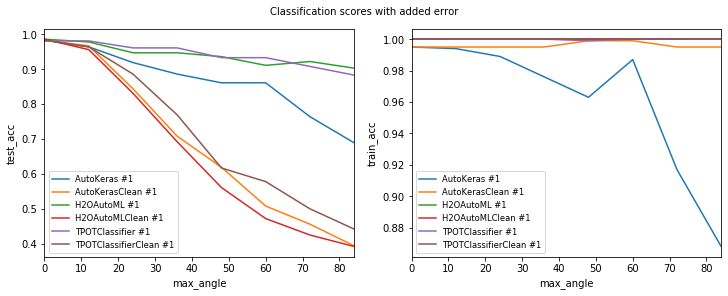

In [10]:
print_results_by_model(
    df, 
    ["train_labels", "test_labels"],
    err_param_name="max_angle",
    pipeline_name="best_pipeline",
)
visualize(df)